In [ ]:
"""Task 1"""

import sys
AIMA_TOOLBOX_ROOT="/Users/wwwLA/Desktop/ai_coursework/aima-python-uofg_v20212022a/aima-python-uofg_v20212022a"
sys.path.append(AIMA_TOOLBOX_ROOT)

In [3]:
from mazelib import Maze
from mazelib.generate.Prims import Prims
from utils import memoize, PriorityQueue

In [4]:
import random
from mazelib.solve.BacktrackingSolver import BacktrackingSolver

def gen_maze_with_teleports(n, t):
    """
    Generate a random maze with teleportation links

    n: size of the maze (n x n)
    t: number of teleportaion links
    
    return: maze object, dictionary of teleportation links
    """
    
    # create the maze
    m = Maze()
    m.generator = Prims(int(n/2), int(n/2))
    m.generate()
    m.generate_entrances(True, True)

    # add teleportation links
    cells = [(x, y) for x in range(len(m.grid)) for y in range(len(m.grid[0])) if m.grid[x][y] == 0]
    teleport_links = {}

    while len(teleport_links) < t:
        source = random.choice(cells)
        destination = random.choice(cells)

        if source != destination and source not in teleport_links and destination not in teleport_links.values():
            teleport_links[source] = destination

    return m, teleport_links

In [ ]:
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens
from search import Problem

class MazeProblem(Problem):
    def __init__(self, initial, goal, maze, teleports=None):
        """
        initial: The starting position (x, y)
        goal: The goal position (x, y)
        maze: A 2D list where 0 represents a wall and 1 represents an open path
        teleports: Dictionary of teleportation links {source: destination}
        """
        self.initial = initial
        self.goal = goal
        self.maze = maze.grid
        self.teleports = teleports or {}  # All teleports (unknown to agent initially)
        self.discovered_teleports = {}   # Tracks only teleports discovered during traversal

    def actions(self, state):
        """Return the possible actions from a given state, including teleportation."""
        actions = []
        x, y = state

        # Standard movement actions
        if x > 0 and (self.maze[x - 1][y] == 0 or (x - 1, y) == self.goal):  # Up
            actions.append('up')
        if x < len(self.maze) - 1 and (self.maze[x + 1][y] == 0 or (x + 1, y) == self.goal):  # Down
            actions.append('down')
        if y > 0 and (self.maze[x][y - 1] == 0 or (x, y - 1) == self.goal):  # Left
            actions.append('left')
        if y < len(self.maze[0]) - 1 and (self.maze[x][y + 1] == 0 or (x, y + 1) == self.goal):  # Right
            actions.append('right')

        # Teleport action (only include discovered teleports)
        if state in self.discovered_teleports:
            actions.append('teleport')

        return actions

    def result(self, state, action):
        """Return the resulting state after taking an action."""
        x, y = state
        if action == 'up':
            return (x - 1, y)
        elif action == 'down':
            return (x + 1, y)
        elif action == 'left':
            return (x, y - 1)
        elif action == 'right':
            return (x, y + 1)
        elif action == 'teleport' and state in self.discovered_teleports:
            # Jump to the teleport destination
            return self.discovered_teleports[state]

    def discover_teleport(self, state):
        """
        Discover the teleport destination for the current state if it is a teleport input.
        """
        if state in self.teleports and state not in self.discovered_teleports:
            self.discovered_teleports[state] = self.teleports[state]

    def is_goal(self, state):
        """Return True if the state is the goal state."""
        return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Calculate the path cost."""
        return c + 1
    
    # def h(self, node):
    #     """Manhattan heuristic for A* search."""
    #     x1, y1 = node.state
    #     x2, y2 = self.goal

    #     # Include discovered teleports in heuristic calculation
    #     direct_distance = abs(x1 - x2) + abs(y1 - y2)
    #     teleport_distances = []
    #     for teleport_in, teleport_out in self.discovered_teleports.items():
    #         # Cost to use teleport
    #         to_teleport_cost = abs(teleport_in[0] - x1) + abs(teleport_in[1] - y1)
    #         from_teleport_cost = abs(teleport_out[0] - x2) + abs(teleport_out[1] - y2)
    #         teleport_distances.append(to_teleport_cost + from_teleport_cost)

    #     # Use the minimum of direct and teleport-enhanced distances
    #     return min([direct_distance] + teleport_distances)

In [6]:
from collections import OrderedDict

class FrontierQ(OrderedDict):
    "A Frontier that supports FIFO or LIFO Queue ordering."
    
    def __init__(self, initial, LIFO=False):
        """Initialize Frontier with an initial Node.
        If LIFO is True, pop from the end first; otherwise from front first."""
        super(FrontierQ, self).__init__()
        self.LIFO = LIFO
        self.add(initial)
    
    def add(self, node):
        "Add a node to the frontier."
        self[node.state] = node
        
    def pop(self):
        "Remove and return the next Node in the frontier."
        (state, node) = self.popitem(self.LIFO)
        return node
    
    def replace(self, node):
        "Make this node replace the nold node with the same state."
        del self[node.state]
        self.add(node)

In [ ]:
class Node(object):
    """A node in a search tree. A search tree is spanning tree over states.
    A Node contains a state, the previous node in the tree, the action that
    takes us from the previous state to this state, and the path cost to get to 
    this state. If a state is arrived at by two paths, then there are two nodes 
    with the same state."""

    def __init__(self, state, parent=None, action=None, path_cost=1):
        "Create a search tree Node, derived from a previous Node by an action."
        self.state     = state
        self.parent    = parent
        self.action    = action
        self.path_cost = path_cost

    def __repr__(self): return "<Node {}: {}>".format(self.state, self.path_cost)
    
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    def child_node(self, problem, action):
        "The Node you get by taking an action from this Node."
        next_state = problem.result(self.state, action)
        return Node(next_state, self, action, 
                    problem.path_cost(self.path_cost, self.state, action, next_state))   
    
    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]
    
    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

In [176]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define the custom colormap
def animate_search(problem, visited, frontier, solution_path=None):
    """
    Animate the current state of the search with a custom colormap.
    
    Parameters:
    - problem: Problem instance containing the maze grid.
    - visited: List of nodes that have been visited.
    - frontier: List of nodes currently in the frontier.
    """
    cmap = ListedColormap(['white', 'black', 'green', 'red', 'blue', 'orange'])

    grid = np.copy(problem.maze)

    sr, sc = problem.initial
    gr, gc = problem.goal

    teleport_links = problem.teleports

    # Highlight solution path in red if provided
    if solution_path:
        for node in solution_path:
            r, c = node
            grid[r, c] = 2  # Mark solution path as red
        grid[sr, sc] = 2
        grid[gr, gc] = 2
        
    else:
        # Color visited nodes (blue)
        for r, c in visited:
            if grid[r, c] == 0:  # Only update unvisited nodes
                grid[r, c] = 4

        # Color frontier nodes (orange)
        for r, c in frontier:
            if grid[r, c] == 0:  # Only update unvisited nodes
                grid[r, c] = 5
        
        # Highlight start and goal (blue, green)
        grid[sr, sc] = 4
        grid[gr, gc] = 2

    # Plot the grid
    grid = np.clip(grid, 0, 5)  # Ensure values are within the range of the colormap
    plt.imshow(grid, cmap=cmap, interpolation='none')

    # Add teleport tiles as circles
    if problem.teleports:
            for teleport_src, teleport_dst in problem.teleports.items():
                plt.scatter(teleport_src[1], teleport_src[0], s=200, c='purple', edgecolors='black', label='Teleport Source')
                plt.scatter(teleport_dst[1], teleport_dst[0], s=200, c='yellow', edgecolors='black', label='Teleport Destination')
     
    # Add minor gridlines
    plt.grid(color='gray', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(-0.5, grid.shape[1], 1), [])
    plt.yticks(np.arange(-0.5, grid.shape[0], 1), [])
    plt.gca().set_xticks(np.arange(0, grid.shape[1]), minor=True)
    plt.gca().set_yticks(np.arange(0, grid.shape[0]), minor=True)
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Add a key/legend
    if not solution_path:
        handles = [
                plt.Line2D([0], [0], color='green', lw=4, label='Goal'),
                plt.Line2D([0], [0], color='blue', lw=4, label='Visited'),
                plt.Line2D([0], [0], color='orange', lw=4, label='Frontier'),
                plt.Line2D([0], [0], marker='o', color='purple', markersize=10, label='Teleport Source', markerfacecolor='purple'),
                plt.Line2D([0], [0], marker='o', color='yellow', markersize=10, label='Teleport Destination', markerfacecolor='yellow')
            ]
        plt.legend(handles=handles, loc='lower right', fontsize='x-small', frameon=True).get_frame().set_alpha(0.5)

    # Add title
    plt.title("Final Solution Path" if solution_path else "Maze Search Visualization")
    plt.pause(0.3)  # Pause to create animation effect
    plt.clf()

In [74]:
def state_sequence(path):
    return [n.state for n in path]

In [372]:
def breadth_first_search(problem, visualize=True):
    "Search for goal; paths with least number of steps first."
    if problem.is_goal(problem.initial):
        print(problem.initial) 
        return Node(problem.initial)
    
    frontier = FrontierQ(Node(problem.initial), LIFO=False)
    explored = set()

    iterations = 0
    
    while frontier:
        node = frontier.pop()
        explored.add(node.state)
        problem.discover_teleport(node.state)
        if problem.is_goal(node.state):
            if visualize:
                animate_search(problem, visited=list(explored), frontier=[], solution_path=state_sequence(node.path()))
            return node, explored
        
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            if child.state not in explored and child.state not in frontier:
                frontier.add(child)
                if visualize and iterations % 3 == 0:
                    # Update visualization at this step
                    animate_search(problem, visited=list(explored), frontier=[n.state for n in frontier.values()])
        iterations += 1

    return None

In [374]:
def depth_first_search(problem, visualize=True):
    "Search for goal; paths with least number of steps first."
    if problem.is_goal(problem.initial):
        print(problem.initial) 
        return Node(problem.initial)
    
    frontier = FrontierQ(Node(problem.initial), LIFO=True)
    explored = set()

    iterations = 0
    
    while frontier:
        node = frontier.pop()
        explored.add(node.state)
        problem.discover_teleport(node.state)
        if problem.is_goal(node.state):
            if visualize:
                animate_search(problem, visited=list(explored), frontier=[], solution_path=state_sequence(node.path()))
            return node, explored
        
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            if child.state not in explored and child.state not in frontier:
                frontier.add(child)
                if visualize and iterations % 3 == 0:
                    # Update visualization at this step
                    animate_search(problem, visited=list(explored), frontier=[n.state for n in frontier.values()])
        iterations += 1

    return None

In [ ]:
# def best_first_search(problem, f, visualize):
#     f = memoize(f, 'f')
#     node = Node(problem.initial)
#     frontier = PriorityQueue('min', f)
#     frontier.append(node)
#     explored = set()

#     iterations = 0

#     while frontier:
#         node = frontier.pop()
#         if problem.is_goal(node.state):
#             if visualize:
#                 animate_search(
#                         problem,
#                         visited=list(explored),  # Current visited nodes
#                         frontier=[n.state for _, n in frontier.heap],  # Current frontier
#                         solution_path=state_sequence(node.path())
#                     )
#             return node, explored
#         explored.add(node.state)

#         problem.discover_teleport(node.state)
        
#         for child in node.expand(problem):
#             if child.state not in explored and child not in frontier:
#                 frontier.append(child)
#             elif child in frontier:
#                 incumbent = frontier[child]
#                 if f(child) < f(incumbent):
#                     del frontier[incumbent]
#                     frontier.append(child)
#             if visualize and iterations % 3 == 0:
#                     animate_search(
#                             problem,
#                             visited=list(explored),  # Current visited nodes
#                             frontier=[n.state for _, n in frontier.heap]  # Current frontier
#                         )
#         iterations+=1
#     return None

# def astar_search(problem, h=None, visualize=True):
#     h = memoize(h or problem.h, 'h')
#     return best_first_search(problem, lambda n: n.path_cost + h(n), visualize)

In [ ]:
# import math 

# def manhattan_distance(current, goal):
#     x1, y1 = current
#     x2, y2 = goal
#     return abs(x1 - x2) + abs(y1 - y2)

# def euclidean_distance(current, goal):
#     x1, y1 = current
#     x2, y2 = goal
#     return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [370]:
N = 10
T = 2
m, teleport_links = gen_maze_with_teleports(N, T)

problem = MazeProblem(m.start, m.end, m, teleport_links)
print(problem.initial, problem.goal)
print(m)
print(teleport_links)

(0, 1) (10, 5)
#S#########
#   # #   #
### # # ###
#         #
# ### # ###
#   # #   #
# ##### ###
# #       #
####### # #
#       # #
#####E#####
{(3, 2): (7, 5), (3, 3): (9, 6)}


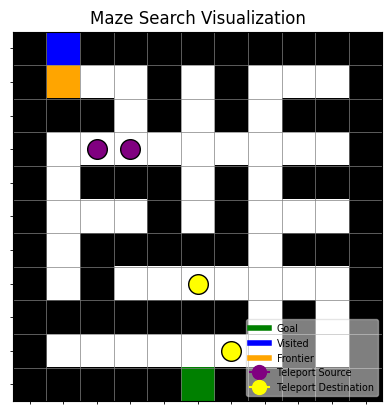

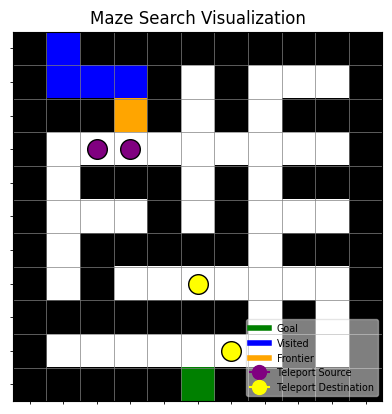

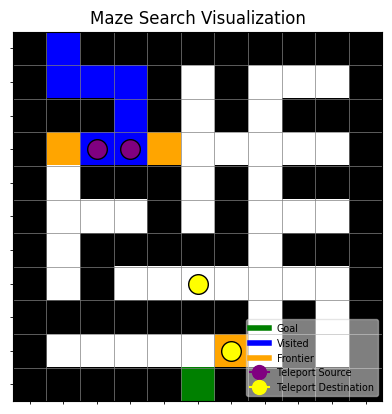

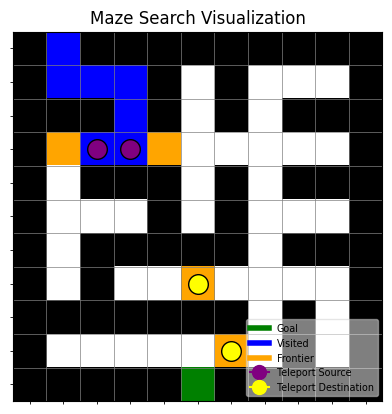

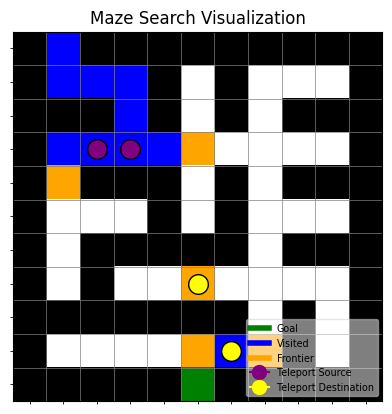

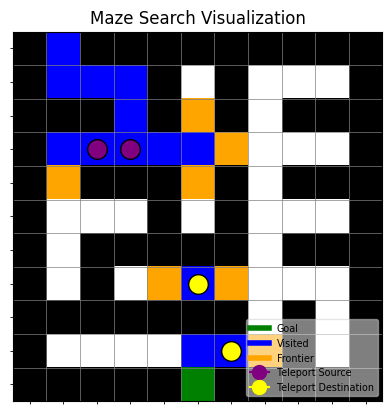

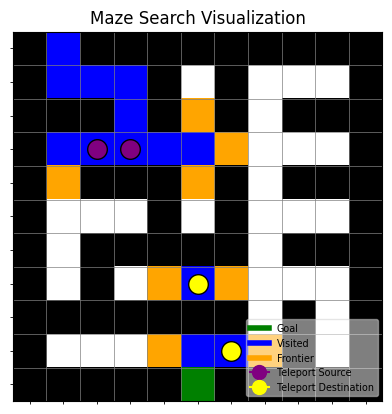

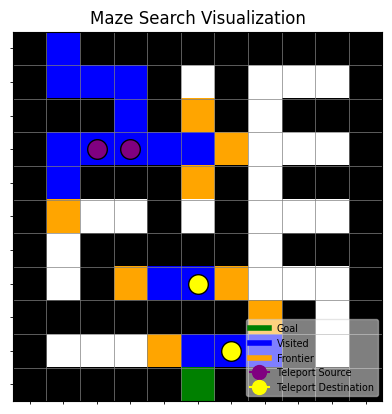

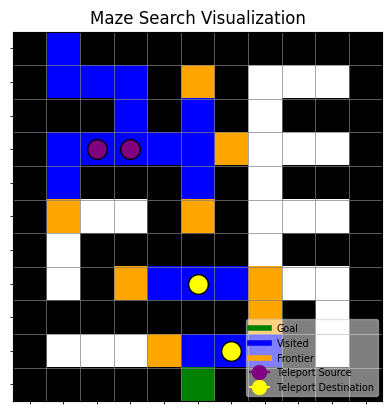

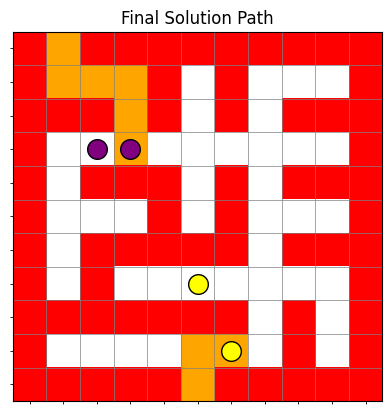

<Figure size 640x480 with 0 Axes>

In [373]:
bfs, bfs_explored = breadth_first_search(problem, visualize=True)

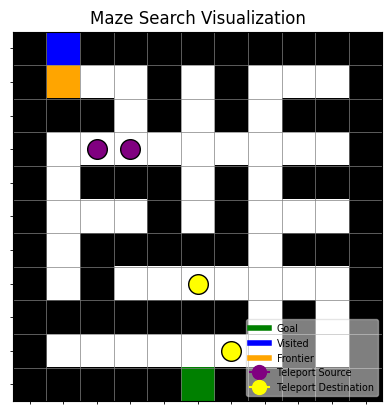

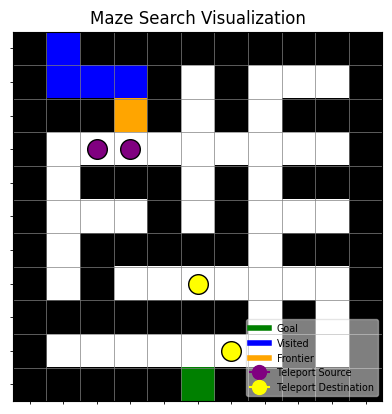

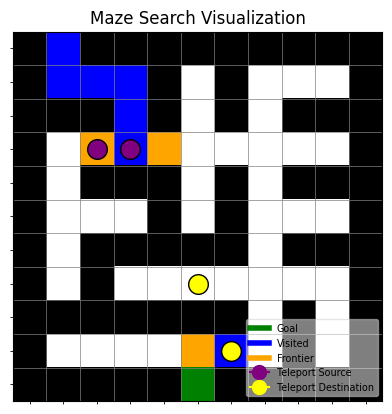

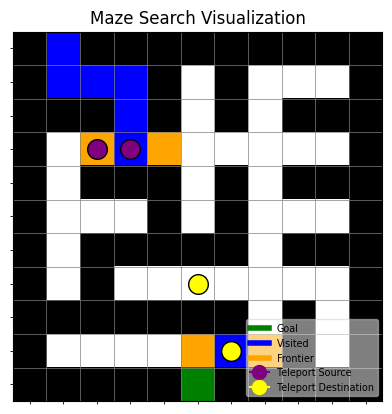

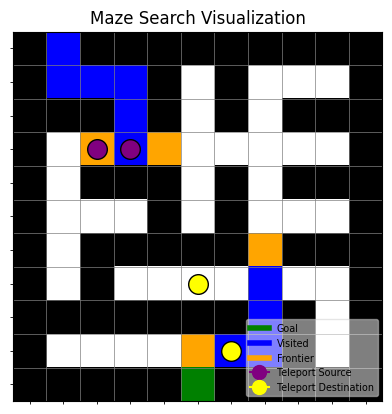

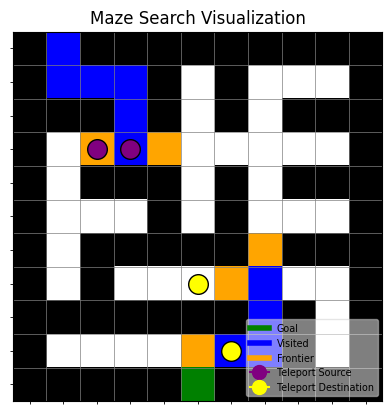

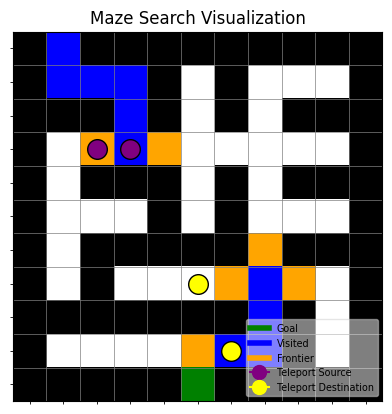

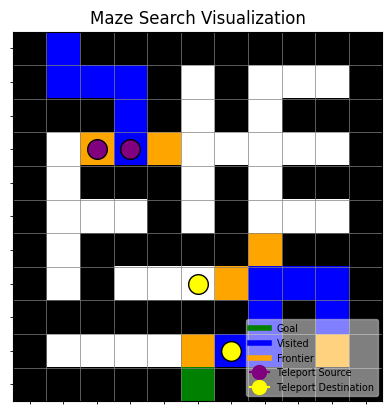

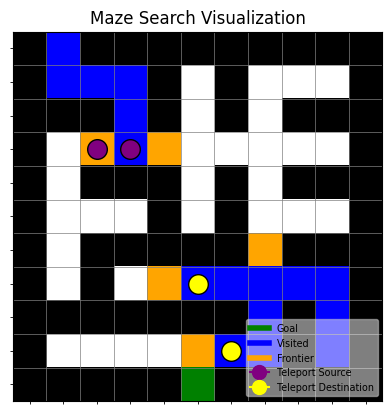

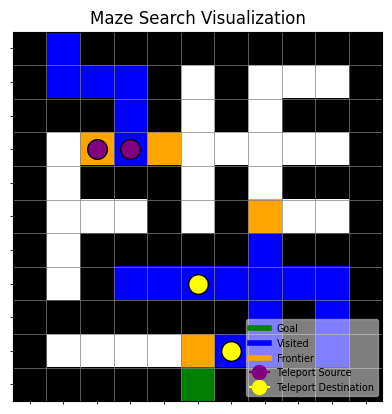

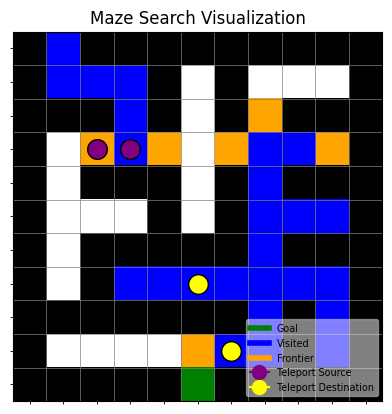

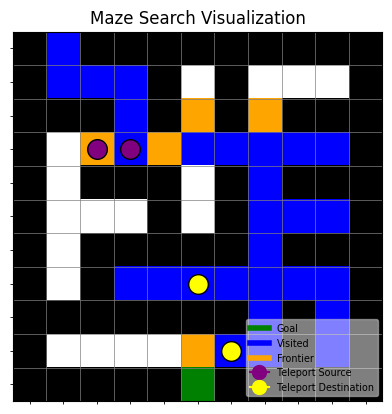

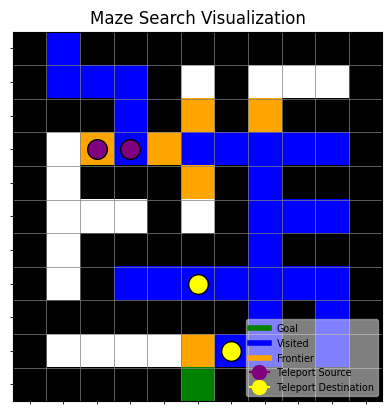

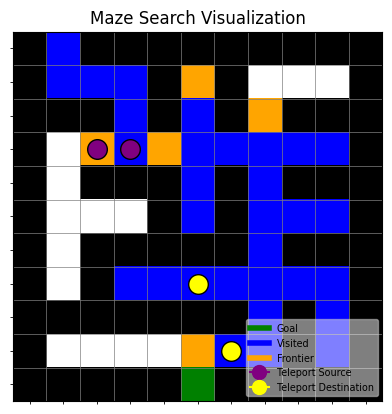

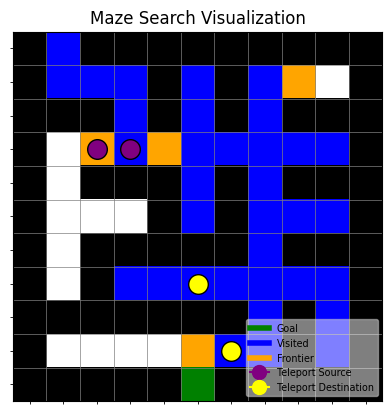

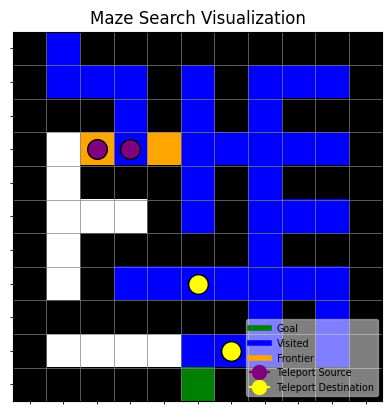

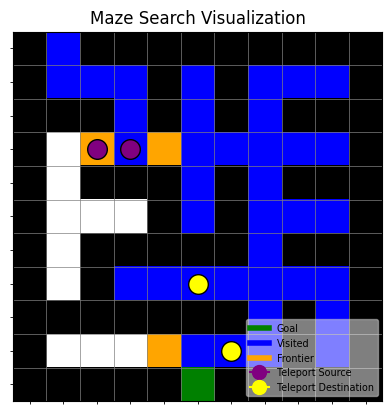

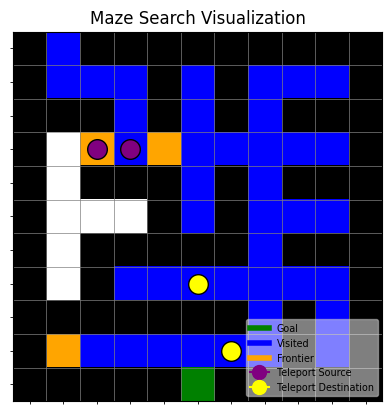

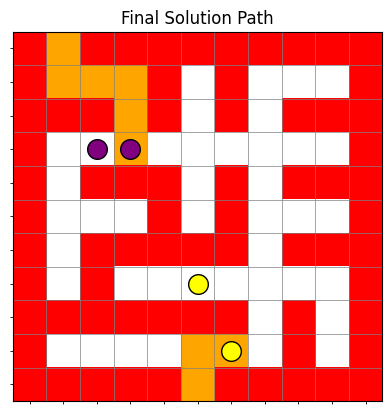

<Figure size 640x480 with 0 Axes>

In [375]:
dfs, dfs_explored = depth_first_search(problem, visualize=True)

In [376]:
# Timing results
print(f"Timing breadth_first_search:")
%timeit -n 10000 -r 10 breadth_first_search(problem, visualize=False)

print(f'\nTiming depth_first_search:')
%timeit -n 10000 -r 10 depth_first_search(problem, visualize=False)

Timing breadth_first_search:
112 μs ± 1.71 μs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)

Timing depth_first_search:
210 μs ± 2.27 μs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [377]:
def get_solution_cost(node):
    return node.path_cost if node else float('inf')

def get_len_explored(explored):
    return len(explored)

# Print metrics
print("BFS Explored:", get_len_explored(bfs_explored), "Nodes, The Solution Cost Was:", get_solution_cost(bfs))
print("DFS explored:", get_len_explored(dfs_explored), "Nodes, The Solution Cost Was:", get_solution_cost(dfs))

BFS Explored: 21 Nodes, The Solution Cost Was: 9
DFS explored: 42 Nodes, The Solution Cost Was: 9


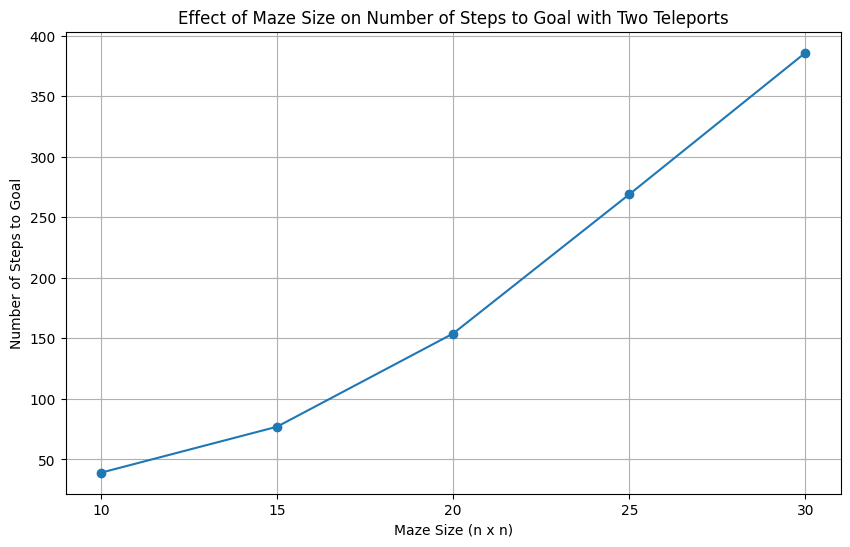

In [ ]:
"""Task 2"""

N_list = [10, 15, 20, 25, 30]
T_2 = 2

steps = []

for n in N_list:
    m_n, tp = gen_maze_with_teleports(n, T_2)
    problem = MazeProblem(m_n.start, m_n.end, m_n, teleport_links)
    _, explored = breadth_first_search(problem, visualize=False)
    steps.append(get_len_explored(explored))

plt.figure(figsize=(10, 6))
plt.plot(N_list, steps, marker='o')
plt.title("Effect of Maze Size on Number of Steps to Goal with Two Teleports")
plt.xticks(N_list)
plt.xlabel("Maze Size (n x n)")
plt.ylabel("Number of Steps to Goal")
plt.grid()
plt.show()

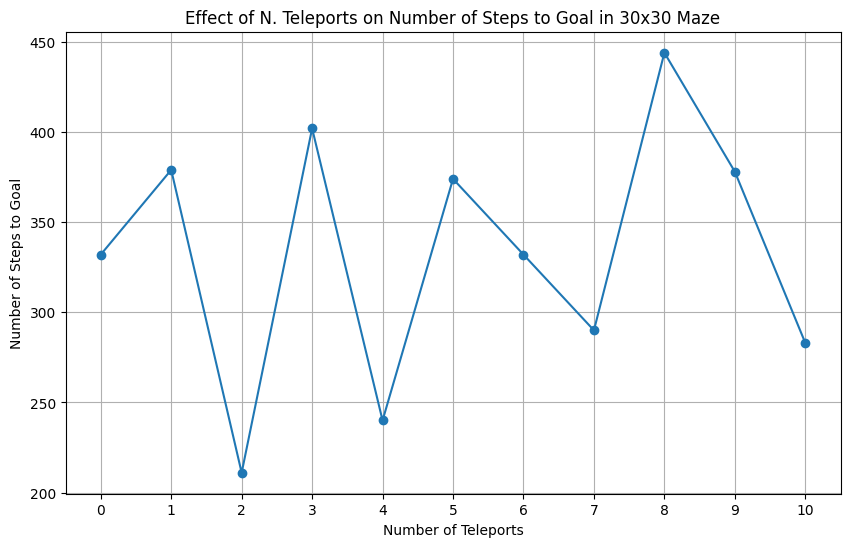

In [390]:
"""Task 3"""
n = 30
T_List = [n for n in range(0, 11)]

steps = []

for t in T_List:
    m_n, tp = gen_maze_with_teleports(n, t)
    problem = MazeProblem(m_n.start, m_n.end, m_n, teleport_links)
    _, explored = breadth_first_search(problem, visualize=False)
    steps.append(get_len_explored(explored))

plt.figure(figsize=(10, 6))
plt.plot(T_List, steps, marker='o')
plt.title("Effect of N. Teleports on Number of Steps to Goal in 30x30 Maze")
plt.xticks(T_List)
plt.xlabel("Number of Teleports")
plt.ylabel("Number of Steps to Goal")
plt.grid()
plt.show()